In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode

### Описание данных
Имеются следующие данные:
date – дата (2020-03-02 00:00:00 – 2020-03-02 01:29:05)  
name – имя пользователя  
transaction – статус транзакции  
minute – сколько минут прошло с начала дня  

1. Загрузите датасет transaction_data.csv. Проверьте размер таблицы, типы переменных, число пропущенных значений и описательную статистику.

In [2]:
# Ссылка с необходимыми данными
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/lyKNd0eq2mb9-A'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [3]:
# Загружаем таблицу с данными
transaction_data = pd.read_csv(download_url, parse_dates=['date'])
transaction_data.head()

,date,name,transaction,minute
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled,37
1,2020-03-02 00:59:09,Irina_Fedorova,successfull,59
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull,6
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled,2
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled,17


In [4]:
# Проверяем тип данных и наличие пустых значений
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5315 entries, 0 to 5314
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5315 non-null   datetime64[ns]
 1   name         5315 non-null   object        
 2   transaction  5315 non-null   object        
 3   minute       5315 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 166.2+ KB


2. Какие значения находятся в колонке transaction? Сколько наблюдений относятся к тому или иному уровню? Визуализируйте результат с помощью барплота

In [5]:
transaction = transaction_data \
              .transaction.value_counts() \
              .reset_index() \
              .rename(columns={'index': 'transaction', 'transaction': 'transaction_counts'})
transaction

,transaction,transaction_counts
0,successfull,3692
1,cancelled,1619
2,error,4


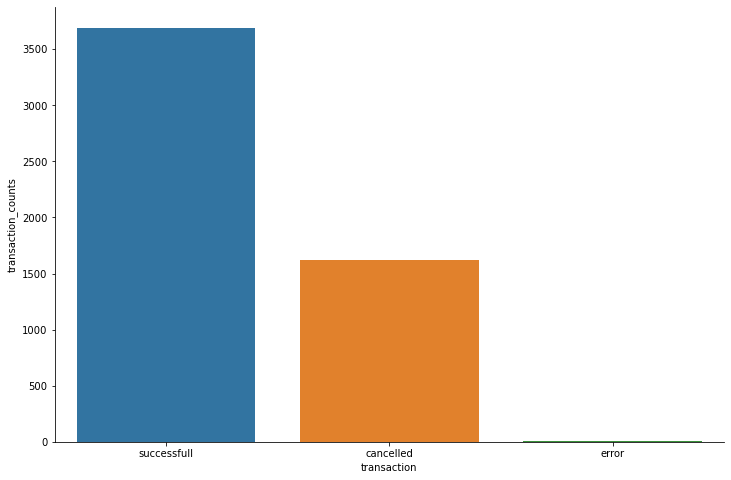

In [6]:
plt.figure(figsize=(12, 8))
sns.barplot(data=transaction, x='transaction', y='transaction_counts')
sns.despine()

In [7]:
transaction_data.head()

,date,name,transaction,minute
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled,37
1,2020-03-02 00:59:09,Irina_Fedorova,successfull,59
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull,6
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled,2
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled,17


3. Сколько успешных транзакций осуществил каждый из пользователей? Постройте гистограмму распределения числа успешных транзакций.

In [8]:
# Создаем таблицу с расчетом количества успешных операций и количества пользователей, 
# совершивщих столько успешных операций
success_transaction_users = transaction_data \
                            .query('transaction == "successfull"') \
                            .groupby('name',as_index=False) \
                            .agg({'date': 'count'}) \
                            .sort_values('date',ascending=False) \
                            .groupby('date',as_index=False) \
                            .agg({'name':'count'}) \
                            .rename(columns={'date':'transaction_numbers', 'name': 'user_numbers'})
success_transaction_users

,transaction_numbers,user_numbers
0,46,1
1,52,1
2,55,2
3,56,1
4,57,1
5,58,1
6,59,3
7,60,3
8,61,2
9,62,5


In [9]:
# Строим описательную статистику полученного распределния
success_transaction_users.describe()

,transaction_numbers,user_numbers
count,27.000000,27.000000
mean,66.259259,2.074074
std,9.333944,1.327981
min,46.000000,1.000000
25%,59.500000,1.000000
50%,66.000000,2.000000
75%,73.500000,3.000000
max,82.000000,6.000000


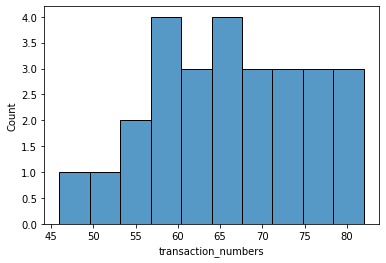

In [10]:
# Строим гистограмму полученного распределния
sns.histplot(success_transaction_users.transaction_numbers,bins=10)
plt.show()

4. Постройте сводную таблицу user_vs_minute_pivot, где в качестве  
столбцов будут использованы имена пользователей,  
строк – минуты,  
значений – число совершенных операций в указанную минуту.

In [11]:
# Строим пивот таблицу в соответствии с требованиями
# Пропущенные значения заполняем нулями, так как в этих промежутках было 0 транзакций
user_vs_minute_pivot = transaction_data \
    .groupby(['name', 'minute'], as_index=False) \
    .agg({'transaction': 'count'}) \
    .pivot(index='minute', columns='name', values='transaction') \
    .fillna(0)
user_vs_minute_pivot.head()

name,Ekaterina_Fedorova,Ekaterina_Ivanova,Ekaterina_Lesnova,Ekaterina_Ozerova,Ekaterina_Petrova,Ekaterina_Polyanova,Ekaterina_Smirnova,Irina_Fedorova,Irina_Ivanova,Irina_Lesnova,...,Svetlana_Petrova,Svetlana_Polyanova,Svetlana_Smirnova,Vasilisa_Fedorova,Vasilisa_Ivanova,Vasilisa_Lesnova,Vasilisa_Ozerova,Vasilisa_Petrova,Vasilisa_Polyanova,Vasilisa_Smirnova
minute,,,,,,,,,,,,,,,,,,,,,
0,3.0,4.0,2.0,3.0,4.0,4.0,2.0,1.0,2.0,2.0,...,0.0,3.0,1.0,1.0,4.0,1.0,3.0,0.0,0.0,1.0
1,4.0,4.0,0.0,4.0,2.0,5.0,4.0,4.0,4.0,3.0,...,4.0,5.0,3.0,2.0,3.0,3.0,0.0,0.0,3.0,2.0
2,1.0,2.0,4.0,4.0,2.0,1.0,3.0,2.0,3.0,3.0,...,4.0,1.0,3.0,3.0,0.0,1.0,2.0,1.0,3.0,1.0
3,3.0,0.0,2.0,0.0,5.0,2.0,1.0,3.0,2.0,2.0,...,1.0,5.0,5.0,2.0,4.0,0.0,3.0,4.0,1.0,0.0
4,3.0,0.0,0.0,3.0,1.0,1.0,2.0,3.0,2.0,1.0,...,1.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,0.0,1.0


5. Коллега построил следующий график по сводной таблице из предыдущего шага, и сомневается, что в данных нет ошибки. Исправьте ошибку коллеги (если она есть 😉), и посчитайте число минут, прошедших с начала дня. Результат сохраните в колонку true_minute. Постройте график, как в предыдущем шаге, и посмотрите, произошли ли изменения

In [12]:
# Построим таблицу, которая получилась у коллеги
user_vs_minute = transaction_data \
    .groupby('minute', as_index=False) \
    .agg({'transaction': 'count'})
user_vs_minute.head()

,minute,transaction
0,0,111
1,1,145
2,2,123
3,3,129
4,4,92


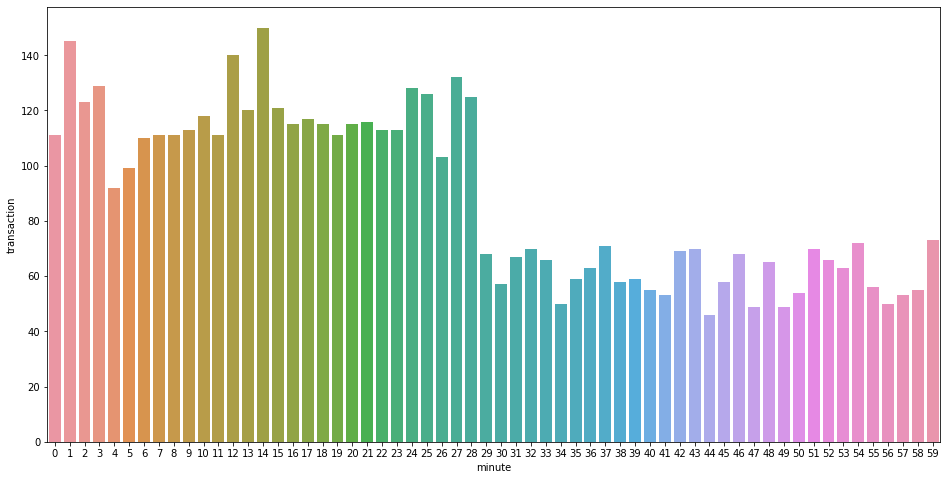

In [13]:
plt.figure(figsize=(16, 8))
sns.barplot(data=user_vs_minute, x='minute', y='transaction')
plt.show()

На первый вгляд из графика бросается количество транзакций в первую и вторую половину часа, до 29 минуты количество транзакций находится в районе 100, а после в районе 60

In [14]:
# Посмтрим описательную статистику столбцов нашей таблицы
transaction_data.describe(datetime_is_numeric=True)

,date,minute
count,5315,5315.000000
mean,2020-03-02 00:43:56.628974592,24.622389
min,2020-03-02 00:00:00,0.000000
25%,2020-03-02 00:21:50.500000,11.000000
50%,2020-03-02 00:43:26,22.000000
75%,2020-03-02 01:06:22.500000,37.000000
max,2020-03-02 01:29:05,59.000000
std,NaN,16.649462


Как мы видим, минуты расписаны только для одно часа, но в наших данных находятся данные о транзакциях до 1:29. То есть нам нужно посчитать количество транзакций в минуту от момента начала работы, а не относительно минут на часах. В данном случае транзакции, совершенные после часа дня, смешались с транзакциями, которые были в первый час работы

In [15]:
# Добавим столбец, который показывает количество минут прошедшие с начала работы
transaction_data['true_minute'] = transaction_data.date.dt.hour.mul(60) + transaction_data.date.dt.minute
transaction_data.head()

,date,name,transaction,minute,true_minute
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled,37,37
1,2020-03-02 00:59:09,Irina_Fedorova,successfull,59,59
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull,6,66
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled,2,2
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled,17,17


In [16]:
user_vs_true_minute = transaction_data \
    .groupby('true_minute', as_index=False) \
    .agg({'transaction': 'count'})
user_vs_true_minute

,true_minute,transaction
0,0,64
1,1,77
2,2,68
3,3,65
4,4,57
...,...,...
85,85,68
86,86,52
87,87,59
88,88,62


In [17]:
# Расчитываем данные для графика, но с обновленным столбцом
user_vs_true_minute = transaction_data \
    .groupby(['name', 'true_minute'], as_index=False) \
    .agg({'transaction': 'count'}) \
    .groupby('true_minute', as_index=False) \
    .agg({'transaction': 'sum'})
user_vs_true_minute

,true_minute,transaction
0,0,64
1,1,77
2,2,68
3,3,65
4,4,57
...,...,...
85,85,68
86,86,52
87,87,59
88,88,62


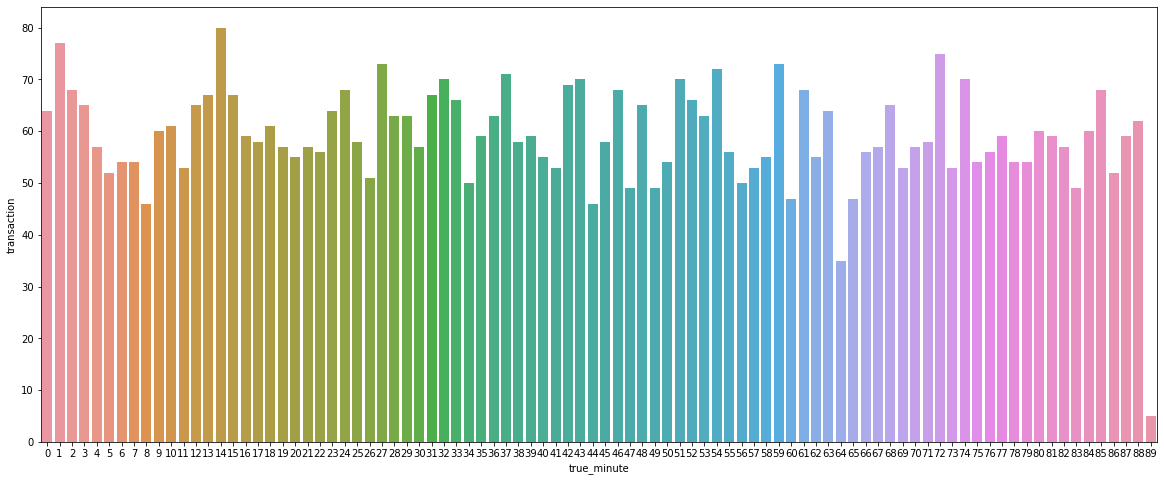

In [18]:
# Строим график, где на оси Х минута с момента начала работы, на оси Y количество транзакций
plt.figure(figsize=(20, 8))
sns.barplot(data=user_vs_true_minute, x='true_minute', y='transaction')
plt.show()